In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import optuna

In [ ]:
# 데이터셋 클래스 정의
class ImageDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = torch.tensor(np.array(data) / 1023.0, dtype=torch.float32).view(-1, 1, 32, 32)  # 정규화
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.labels is None:
            return self.data[idx]
        return self.data[idx], self.labels[idx]

In [ ]:
# ResNet34 모델 정의
class ResNet34Model(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet34Model, self).__init__()
        self.model = models.resnet34(pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 입력 채널 변경
        self.model.fc = nn.Linear(512, num_classes)  # 출력 조정
    
    def forward(self, x):
        return self.model(x)

In [ ]:
# 데이터 불러오기
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
# 레이블 인코딩
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
train_features = train_df.drop(columns=['ID', 'label']).values
test_features = test_df.drop(columns=['ID']).values

In [ ]:
# 데이터 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x=train_df['label'])
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Data")
plt.show()

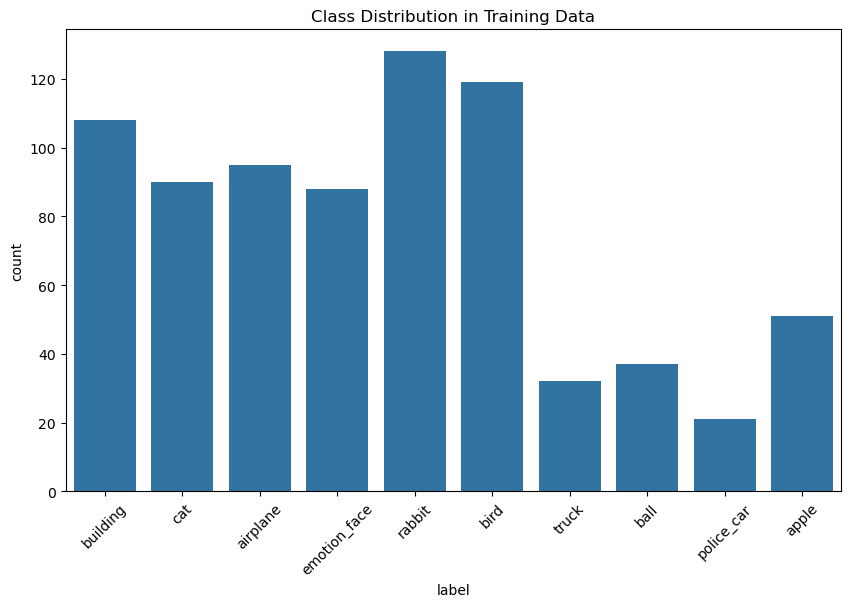

In [ ]:
# 샘플 이미지 확인
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = train_features[i].reshape(32, 32)
    ax.imshow(img, cmap='gray')
    ax.set_title(label_encoder.inverse_transform([train_labels[i]])[0])
    ax.axis('off')
plt.show()

In [ ]:
# 데이터 증강 함수
def add_noise(data, noise_level=0.1):
    noise = np.random.normal(0, noise_level, size=data.shape)
    return data + noise

def scale_data(data, scale_factor=0.5):
    return data * scale_factor

# 데이터 증강 적용
augmented_train_features = []
augmented_train_labels = []
for feature, label in zip(train_features, train_labels):
    # 노이즈 추가
    noisy_feature = add_noise(feature)
    # 스케일링
    scaled_feature = scale_data(feature)
    
    augmented_train_features.extend([feature, noisy_feature, scaled_feature])
    augmented_train_labels.extend([label, label, label])

In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(augmented_train_features, augmented_train_labels, test_size=0.2, random_state=42)

In [ ]:
# Optuna 최적화 함수 정의
def objective(trial):
    # 하이퍼파라미터 샘플링
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    factor = trial.suggest_uniform('factor', 0.1, 0.5)
    patience = trial.suggest_int('patience', 3, 10)
    
    # 데이터로더 생성
    train_dataset = ImageDataset(X_train, y_train)
    val_dataset = ImageDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 모델 및 학습 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet34Model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience, factor=factor)
    
    # 학습
    num_epochs = 10  # Optuna 튜닝에서는 적은 epoch 사용
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # 검증 단계
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        val_accuracy = correct / total
        scheduler.step(val_accuracy)
        
        best_val_acc = max(best_val_acc, val_accuracy)
    
    return best_val_acc

In [ ]:
# Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

In [ ]:
# 최적 하이퍼파라미터 적용
best_params = study.best_params
batch_size = best_params['batch_size']
lr = best_params['lr']
weight_decay = best_params['weight_decay']
factor = best_params['factor']
patience = best_params['patience']

[I 2025-04-01 18:12:57,477] A new study created in memory with name: no-name-c55d2908-7e3f-42e7-94b6-2815a24da9a7
C:\Users\09048\AppData\Local\Temp\ipykernel_14936\526589141.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\09048\AppData\Local\Temp\ipykernel_14936\526589141.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
C:\Users\09048\AppData\Local\Temp\ipykernel_14936\526589141.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

KeyboardInterrupt: 

In [ ]:
# 최적 하이퍼파라미터로 모델 재학습
train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(test_features)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ResNet34Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience, factor=factor)

num_epochs = 15
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

NameError: name 'study' is not defined

In [ ]:
# 데이터셋 및 데이터로더 생성
# NumPy 배열로 변환
X_train = np.array(X_train)
X_val = np.array(X_val)
test_features = np.array(test_features)

train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(test_features)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [ ]:
# 예측 및 저장
model.eval()
predictions = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)

In [ ]:
# 결과 저장
submission = pd.DataFrame({"ID": test_df["ID"], "label": label_encoder.inverse_transform(predictions)})
submission.to_csv("submission.csv", index=False)